In [1]:
# 0. Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# test Dickey-Fuller 
from statsmodels.tsa.stattools import adfuller

# for autocorrelation plot
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Box-Cox
from scipy.stats import boxcox  
from scipy.special import inv_boxcox 

# ARIMA - autoregressive integrated moving average,
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# 1. Init helper methods

# Dickey-Fuller Test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


# calls test_stationarity() and plot Autocorrelation and Quantil-Quantil graph
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    plt.clf()
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05) # автокорреляция
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05) # частичная автокорреляция
        sm.qqplot(y, line='s', ax=qq_ax) # график квантиль-квантиль
        
        plt.tight_layout()
        plt.show()
    return


def plot_ts_and_points(ts, start_point, step):
    plt.clf()
    if not isinstance(ts, pd.Series):
        ts = pd.Series(ts)
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')
        plt.show()

<Figure size 640x480 with 0 Axes>

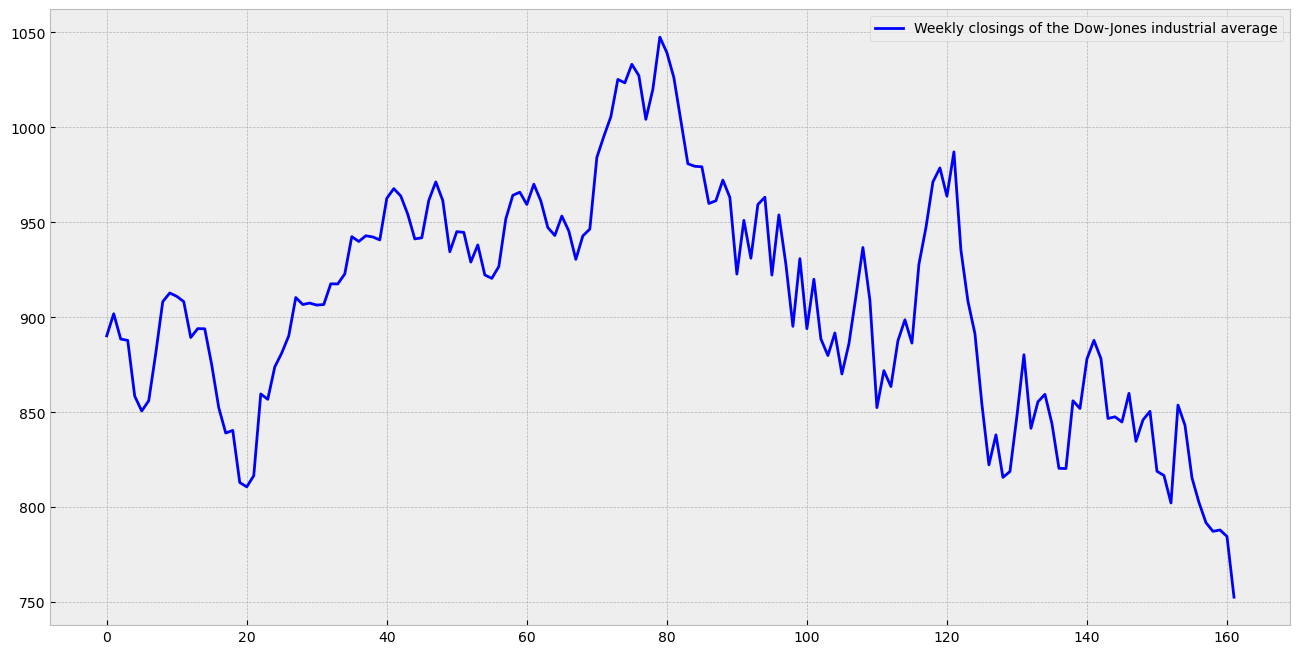

In [3]:
# 2. Init data
dowjones_closing = pd.read_csv("Datasets/weekly-closings-of-the-dowjones-.csv")
#mean_monthly_temp = pd.read_csv("Datasets/mean-monthly-air-temperature-deg.csv")
#robberies_in_boston = pd.read_csv("Datasets/monthly-boston-armed-robberies-j.csv")
#airlines_passengers  = pd.read_csv("Datasets/international-airline-passengers.csv")

all_series = {
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
#    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
#    "Monthly Boston armed robberies": robberies_in_boston["Count"],
#    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"]
}



with plt.style.context(style='bmh'):
    plt.clf()
    plt.figure(figsize=(16, 8))
    ax = plt.axes()
    plt.plot(dowjones_closing['Close'], color='blue', label='Weekly closings of the Dow-Jones industrial average') # original
    plt.legend()
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


<Figure size 640x480 with 0 Axes>

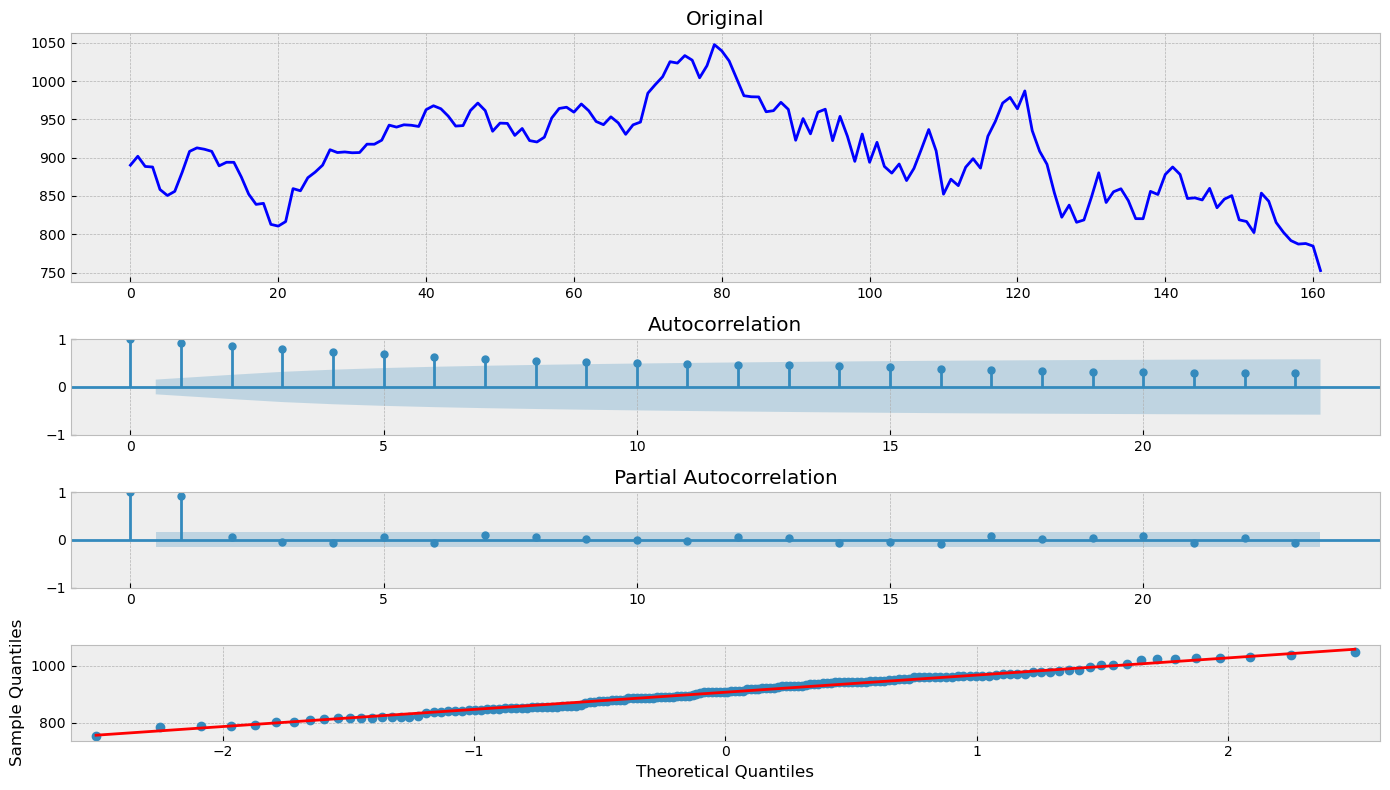

In [4]:
# 4. Plot the TM
tsplot(dowjones_closing['Close'])

# The time series isn't stationary because:
- The mean value and dispersion don't change over the time
- p-value > 0.5
- Autocorrelation doesn't fall quickly

However

- on the QQ graph blue points are almost on the red line

<b> Let's make this TM stationary</b>

Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


<Figure size 640x480 with 0 Axes>

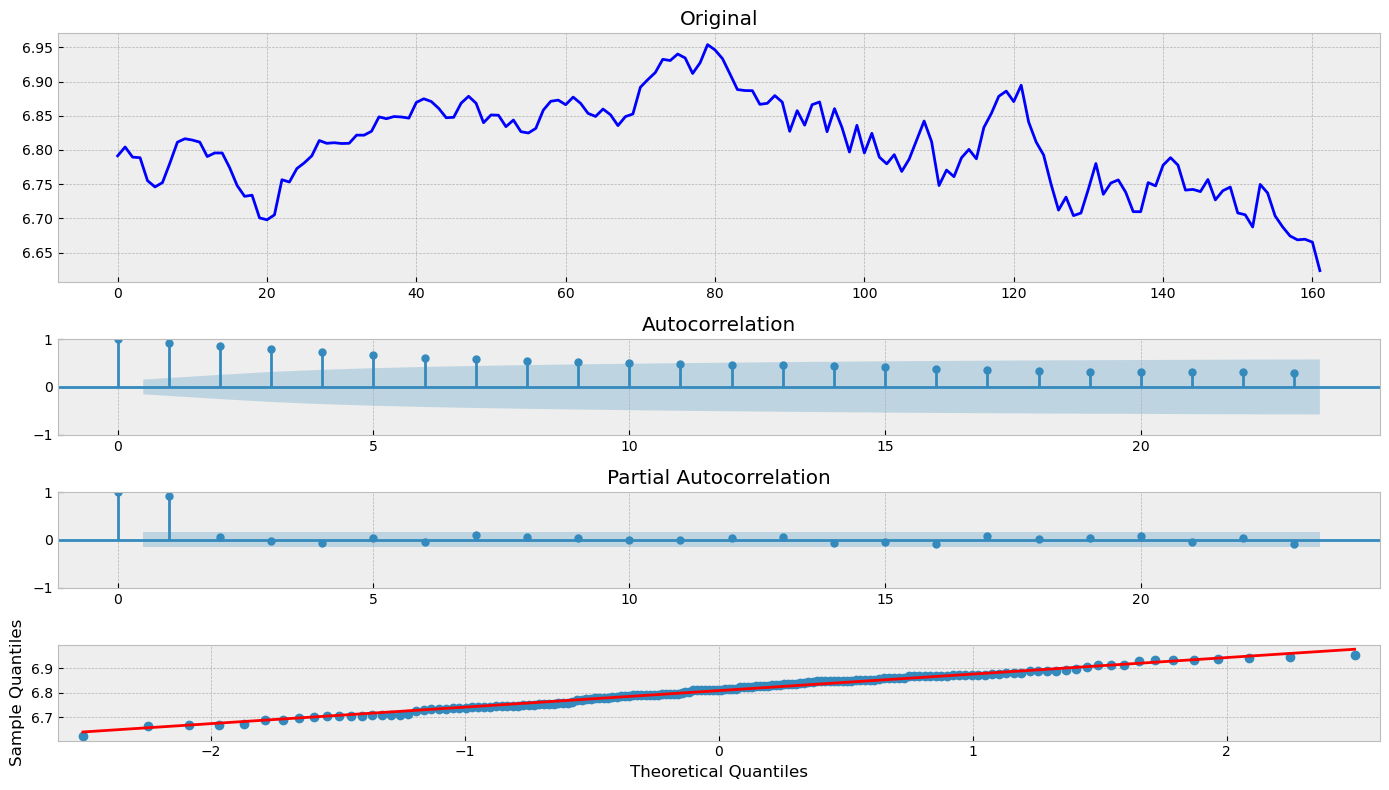

In [5]:
# 5. Box-Cox
series_boxcox = boxcox(dowjones_closing['Close'], 0)
tsplot(series_boxcox)

#### There isn't the equal scope of dispersion, but only the absolute values are decreased.

<Figure size 640x480 with 0 Axes>

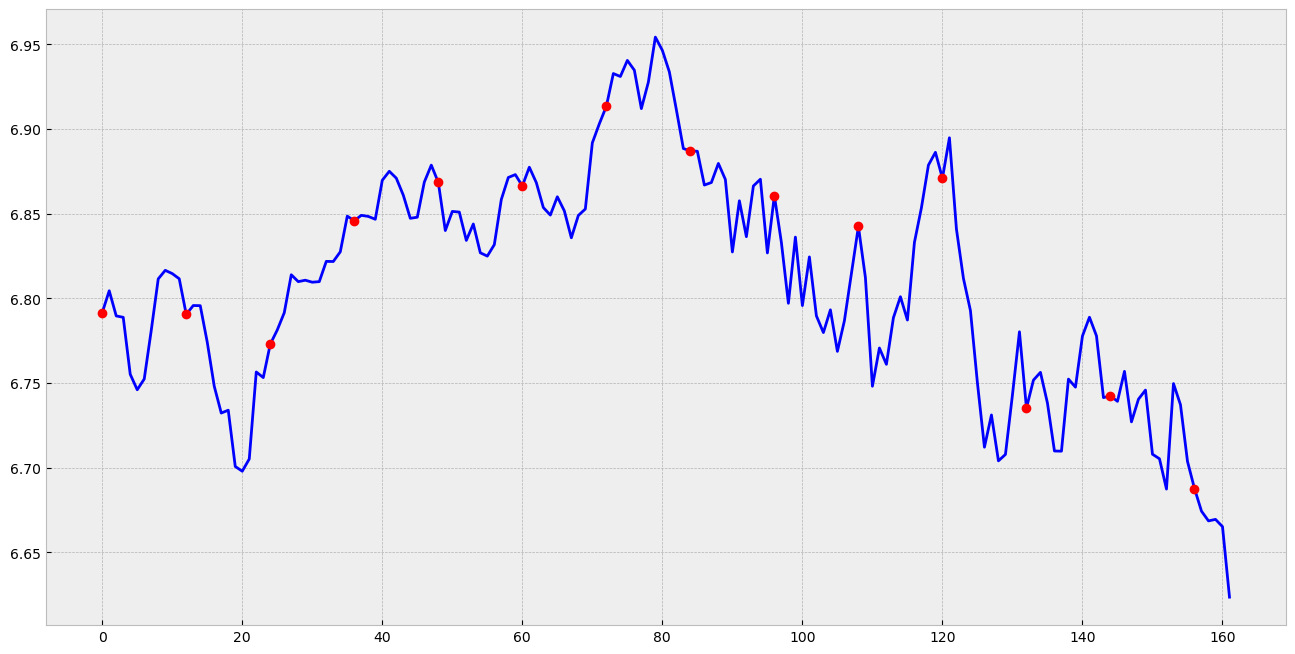

In [6]:
plot_ts_and_points(series_boxcox, 0, 12)

#### There is difficult to say exactly which the seasonality or the trend the TM have. Just take the difference with step 1.

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


<Figure size 640x480 with 0 Axes>

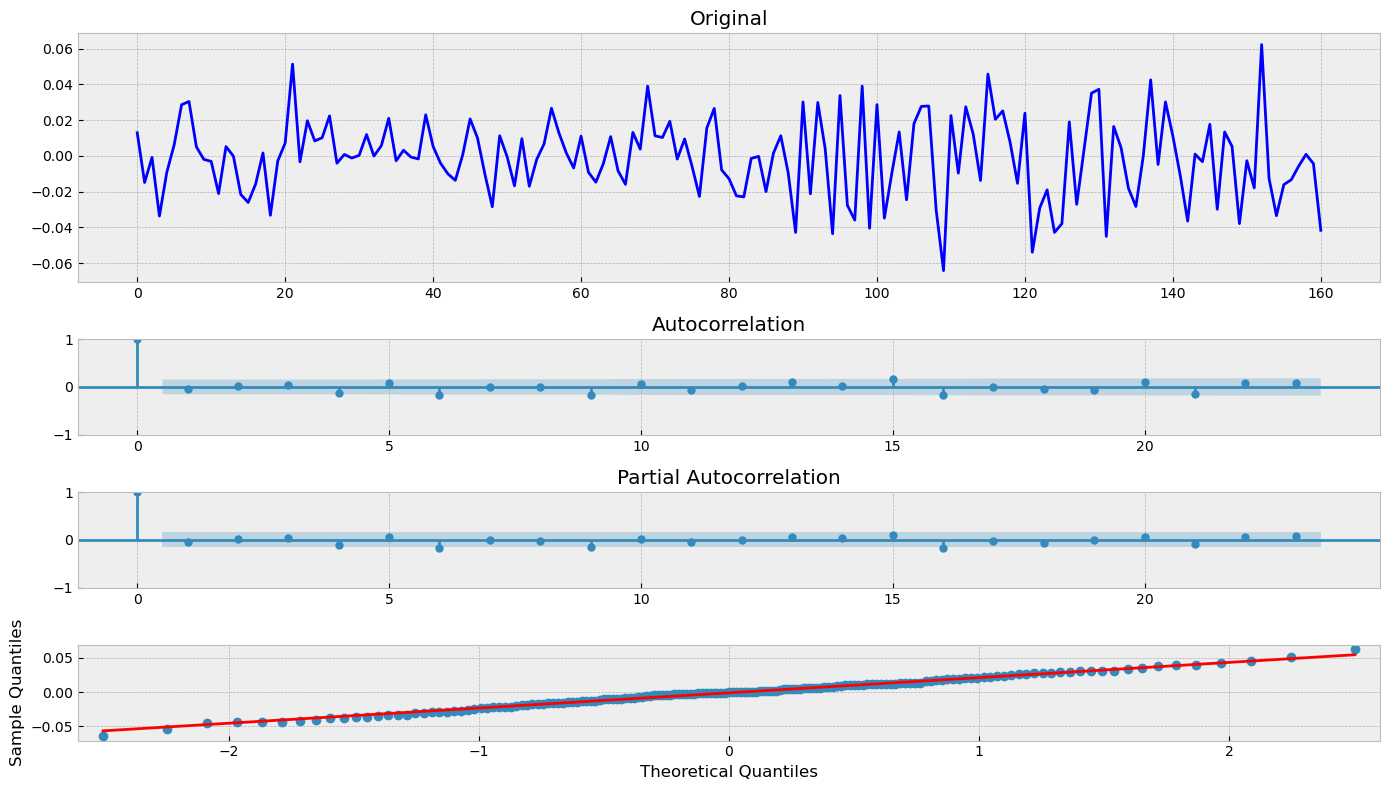

In [7]:
# 6. Difference
ser_diff = np.diff(series_boxcox, 1)
tsplot(ser_diff)

In [57]:
# 7. Fit the ARIMA model
best_aic = np.inf 
best_order = None
best_mdl = None


for i in range(8):
    for d in range(13): 
        for j in range(8):
            try:
                tmp_mdl = ARIMA(ser_diff[:-40], order=(i, d, j), trend='c').fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: -607.48383 | order: (4, 0, 7)


In [58]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(4, 0, 7)   Log Likelihood                 316.742
Date:                Tue, 09 Jul 2024   AIC                           -607.484
Time:                        12:56:32   BIC                           -571.139
Sample:                             0   HQIC                          -592.723
                                - 121                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.391      0.696      -0.003       0.004
ar.L1          0.0942      0.088      1.066      0.286      -0.079       0.267
ar.L2          0.8603      0.093      9.228      0.000       0.678       1.043
ar.L3         -0.1184      0.095     -1.244      0.214      -0.305       0.068
ar.L4         -0.7130      0.107     -6.648      0.000      -0.923      -0.503
ma.L1         -0.0140      2.302     -0.006      0.995      -4.526       4.498
ma.L2         -0.9495      1.349     -0.704      0.482      -3.594       1.695
ma.L3          0.0698      2.952      0.024      0.981      -5.715       5.855
ma.L4          0.6364      3.272      0.195      0.846      -5.777       7.050
ma.L5          0.2921      0.654      0.446      0.655      -0.990       1.574
ma.L6          0.1228      0.531      0.231      0.817      -0.919       1.164
ma.L7         -0.4203      1.380     -0.305      0.761      -3.124       2.284
sigma2         0.0003      0.001      0.296      0.767      -0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.81   Prob(JB):                         0.88
Heteroskedasticity (H):               1.83   Skew:                             0.01
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.93e+16. Standard errors may be unstable.
"""

In [59]:
best_mdl.params

array([ 6.31877346e-04,  9.42489701e-02,  8.60285480e-01, -1.18374004e-01,
       -7.13024325e-01, -1.39963257e-02, -9.49515911e-01,  6.98007827e-02,
        6.36448225e-01,  2.92052919e-01,  1.22845991e-01, -4.20297149e-01,
        2.87905697e-04])

Results of Dickey-Fuller Test:
Test Statistic                -1.104827e+01
p-value                        5.156877e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64


<Figure size 640x480 with 0 Axes>

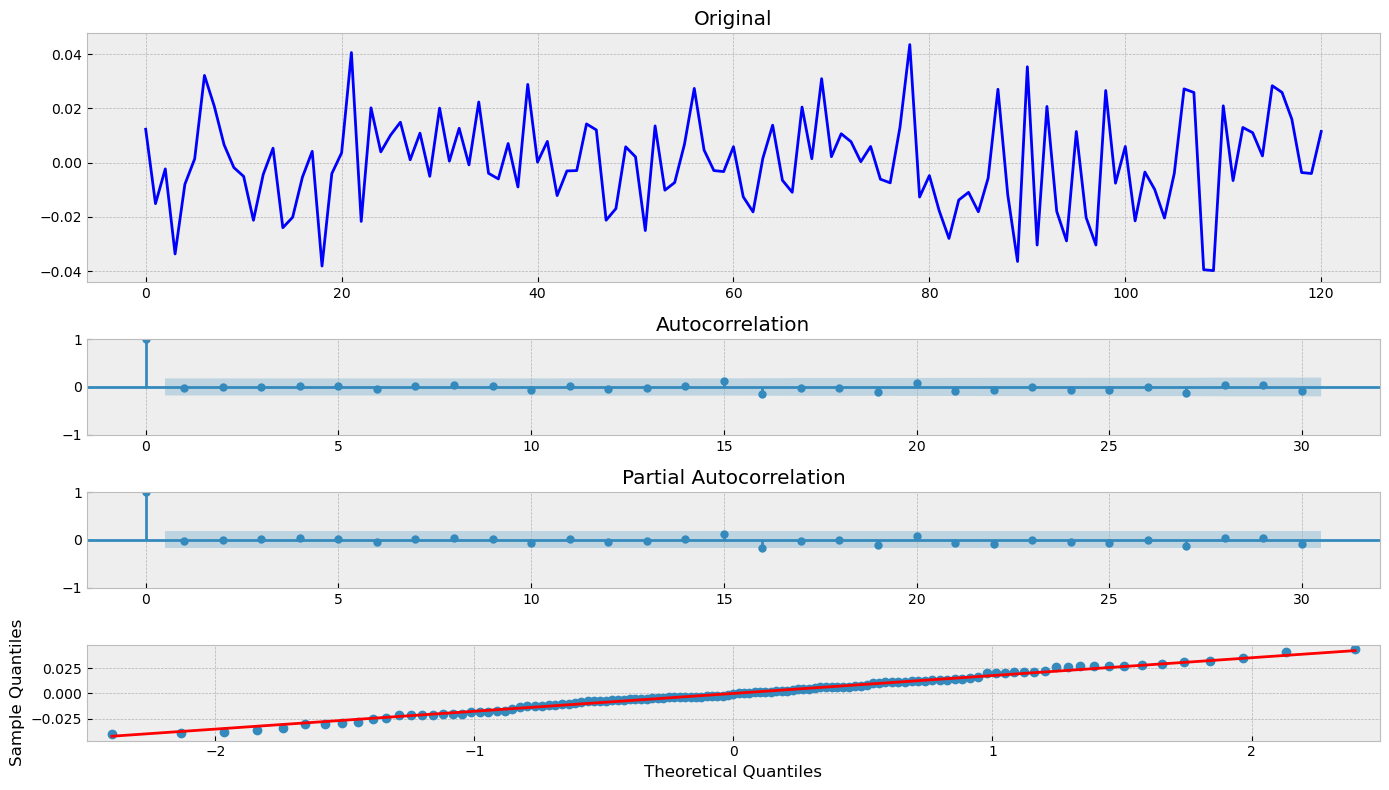

In [60]:
# 8. Plot the residuals
tsplot(best_mdl.resid, lags=30) 

#### There is possible to claim that the residuals of the model is stationary.

In [61]:
# 9. Forecast
predict = best_mdl.predict(start=0, end=len(ser_diff))

# Inverse operation for diff
initial_value = series_boxcox[0]
predict = np.insert(np.cumsum(predict)+[initial_value]*len(predict), 0, initial_value)

# Inverse operation for Box-Cox
predict = inv_boxcox(predict, 0)

<Figure size 640x480 with 0 Axes>

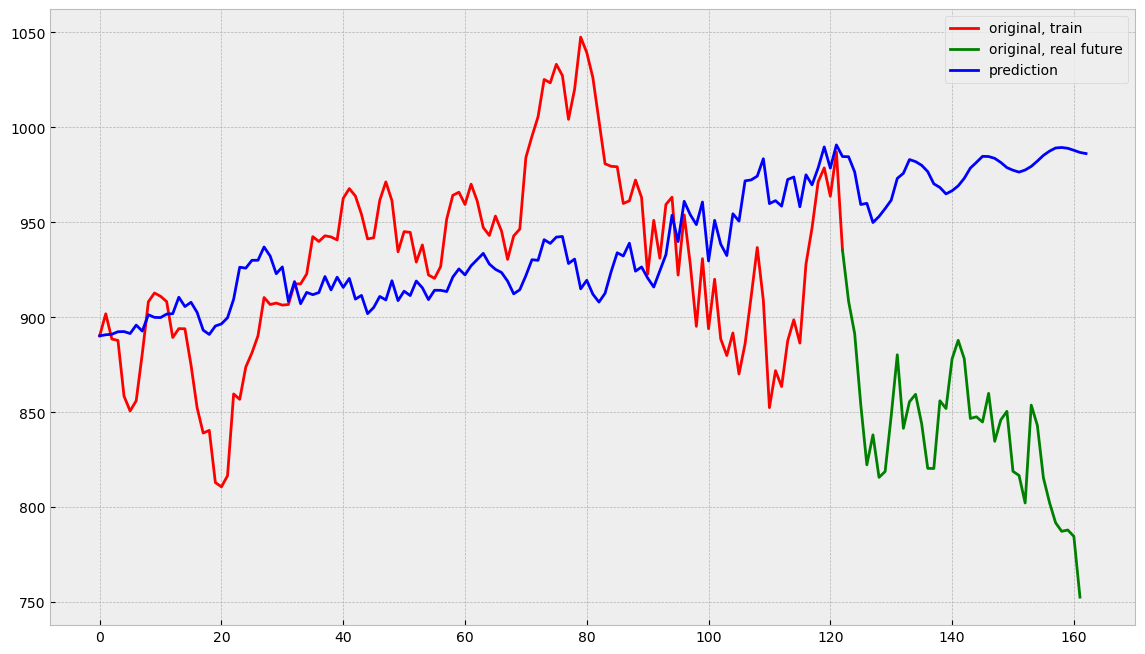

In [63]:
# 10. Plots
with plt.style.context(style='bmh'):
    plt.clf()
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(dowjones_closing['Close'][:-39], color='red', label='original, train') # original
    plt.plot(dowjones_closing['Close'][-40:], color='green', label='original, real future') # original
    plt.plot(predict, color='blue', label='prediction') # mdl.predict

    plt.legend()
    plt.show()

### Got a regression of the 13th order.
### There is a bad result in terms of prediction of dispersion, but it even can predict the real behavior of trend. 